# Classify Electrocardiograms (ECG)

<img src='https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg' width=400>

🧑🏻‍🏫 We saw in the first challenge that **Recurrent Neural Networks are well designed to work with sequence prediction problems**: based on an observed sequence of data, RNNs are used to predict what will happen next (predicting the next value(s) of a temperature, a stock price, ... $ \rightarrow $ ***regression task***).

👉 Let's see a different way to use RNNs. Instead of predicting a value that occurs after the observed sequence, we will ***classify the entire sequence*** itself, as if the whole sequence corresponds to a given category. 

🎯 Exercise objectives:
- Discover a new type of application with temporal data: classification (we will classify heartbeats ❤️)
- Try different RNN architectures.

_PS: No need to use Google Colab_ ❌

## (1) The ECG dataset

* The data corresponds to electrocardiograms (ECG), which are basically heartbeats.
    - Each sequence is therefore a sequence of amplitudes. 
    - These ECGs are often used to observe heart malfunctions! 
* In this dataset, there are 87554 heartbeats and each of them corresponds to a heartbeat type, ranging from 0 to 4:
    - 0 : Normal beat
    - 1 : Supraventricular
    - 2 : Ventricular
    - 3 : Fusion
    - 4 : Beats that cannot be classified

### (1.1) 🎁 Loading the dataset

<u><b>Instructions:</b></u>
* Run the following command to download the data from [here](https://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip)
* Unzip them
* Read the dataset as a Python object

In [2]:
! wget "http://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip"
! unzip ECG_data.zip
! rm ECG_data.zip

zsh:1: command not found: wget
unzip:  cannot find or open ECG_data.zip, ECG_data.zip.zip or ECG_data.zip.ZIP.
rm: ECG_data.zip: No such file or directory


In [3]:
!pwd

/Users/mariazoghzoghi/code/mariazog/data-classify-electrocardiograms


In [16]:
!ls

ECG_data                          classify_electrocardiograms.ipynb
README.md                         tests


In [5]:
import numpy as np

X = np.load('ECG_data/X.npy', allow_pickle=True).tolist()
y = np.load('ECG_data/y.npy', allow_pickle=True).tolist()

print(len(X), "time series") 

87554 time series


In [20]:
# X = np.load('ECG_data/X.npy', allow_pickle=True).tolist()
# y = np.load('ECG_data/y.npy', allow_pickle=True).tolist()
 

### (1.2) 🎁 Visualizing some ECGs

🎁 We gave you a piece of Python code to plot one ECG for each category in the dataset 

👩🏻‍⚕️ *Run the following cell* to catch a glimpse about how an ECG looks like for each category and then move forward to section `(1.3) Padding the sequences` once that you have visualized these ECG.

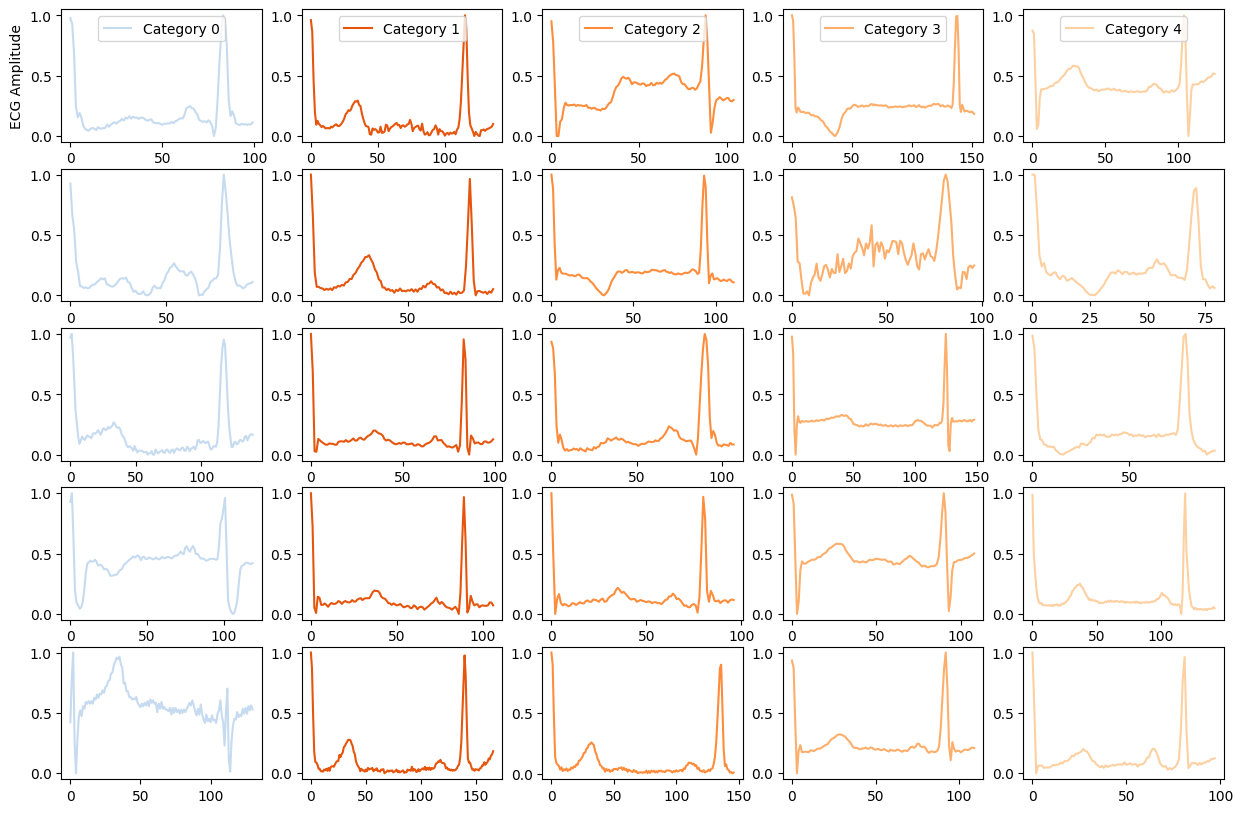

In [7]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# ------------------------- #
#      Some colormaps       #
# ------------------------- #

name = "tab20c"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors_list = cmap.colors


# ------------------------- #
#      Some ECG             #
# ------------------------- #

fix, axs = plt.subplots(5,5, figsize=(15,10))

for i in range(5): # Five examples per category
    for j in range(5): # Iterating over the 5 categories
        idx_C = np.argwhere(np.array(y) == j)  # Collecting the indexes of all the heartbeats of category j
        axs[i,j].plot(X[idx_C[i][0]], label=f'Category {j}', c=colors_list[j+3]) # Plotting the ECG
        # Some cosmetic tricks down below
        if i == 0:
            axs[i,j].legend(loc='upper center')
            if j ==0:
                axs[i,j].set_xlabel('Time')
                axs[i,j].set_ylabel('ECG Amplitude')

In [14]:
import pandas as pd
#df = pd.DataFrame("http://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip")

### (1.3) 💻 Padding the sequences

🕵🏻‍♂️ You have (probably?) noticed that each sequence, i.e. each ECG, has a different length.

❓ **Question** ❓ Plot the distribution of the sequences' lengths in the dataset to confirm this observation.

In [21]:
X

[[0.9779411554336546,
  0.9264705777168274,
  0.6813725233078002,
  0.2450980395078659,
  0.15441176295280454,
  0.19117647409439087,
  0.1519607901573181,
  0.08578431606292723,
  0.05882352963089942,
  0.04901960864663124,
  0.04411764815449715,
  0.06127450987696649,
  0.06617647409439087,
  0.06127450987696649,
  0.04901960864663124,
  0.07352941483259201,
  0.06127450987696649,
  0.06127450987696649,
  0.06617647409439087,
  0.06862745434045793,
  0.09558823704719543,
  0.07598039507865906,
  0.09313725680112839,
  0.10539215803146361,
  0.1151960790157318,
  0.10294117778539656,
  0.11764705926179887,
  0.125,
  0.1421568691730499,
  0.12745098769664764,
  0.1519607901573181,
  0.14460784196853635,
  0.16421568393707278,
  0.14460784196853635,
  0.15931372344493863,
  0.1519607901573181,
  0.15441176295280454,
  0.1421568691730499,
  0.1519607901573181,
  0.1519607901573181,
  0.14705882966518402,
  0.13235294818878174,
  0.12745098769664764,
  0.1348039209842682,
  0.13725490868

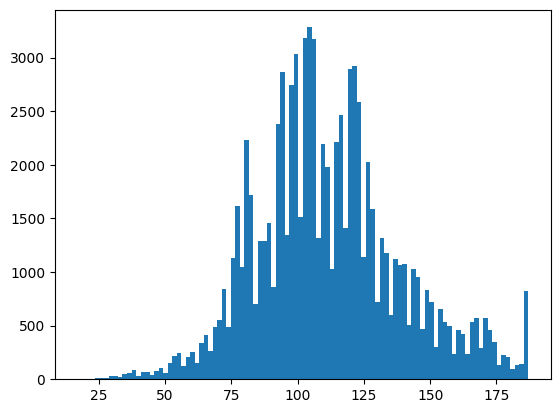

In [24]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
plt.hist([len(x) for x in X], bins=100)

🧑🏻‍🏫 Remember that Neural Networks are fed with tensors, batch per batch. The shape of these tensors is the following:


>`(# SEQUENCES, # OBSERVATIONS per sequence, # FEATURES per observation)`

- `# SEQUENCES` = $87554$ sequences
- `# OBSERVATIONS per sequence` = ❗️***the number of observations varies from one sequence to another one***❗️ 
- `# FEATURES per observation` = each observation collects only $1$ feature = the amplitude of the ECG.

😰 Such a tensor is called a ***ragged tensor***. For computational reasons, this cannot be fed into a Recurrent Neural Network. 

💡 RNNs need to be fed with proper tensors. For this reason, you need to "***fill in the blanks of each sequence***". Using [📚 **`pad_sequences`**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences), each sequence will be filled with fake values. The resulting sequences will all be the same length.

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/DL/tensors_in_rnn.png" alt="Tensors in RNN" width="500" height="600">



👨🏻‍🏫 How will the Recurrent Neural Network know that a zero is a fake value used as a pad for computational reasons? There is a layer called **`Masking`** layer which will inform the RNN to ignore the fake values. 

💡 Best practices when manipulating `pad_sequences`:
* It is better to pad the "missing values" at the end of the sequences with the argument `padding = 'post'`
* You should use a padding value that doesn't make sense for the problem you are tackling. It will be easier for the Network to distinguish the padding value from the other values. _For example, a heartbeat can't be negative_, therefore you could use a padding value `value = -1` here.

❓ **Question** ❓ Apply the 📚 [**`pad_sequences`**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function on X.

- Don't forget the following arguments `dtype`, `padding = 'post'` and `value = -1`
- Store the padded sequences in a variable called `X_pad`
- And print the first padded sequence


In [25]:
# What version of Tensorflow do you have ? 
!pip freeze | grep tensorflow

tensorflow==2.10.0
tensorflow-estimator==2.10.0
tensorflow-io-gcs-filesystem==0.27.0


In [102]:
import tensorflow as tf
X_pad = tf.keras.utils.pad_sequences(X, dtype = 'float32', padding = 'post', value = -1)
X_pad.shape

(87554, 187)

🧪 If you padded properly, the shape of `X_pad` should be equal to $ (87554, 187) $

In [103]:
from nbresult import ChallengeResult

print(f"X_pad.shape = {X_pad.shape}")

result = ChallengeResult('X_pad_shape',
                         X_pad_shape = X_pad.shape)
result.write()
print(result.check())

X_pad.shape = (87554, 187)

============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/mariazoghzoghi/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/mariazoghzoghi/code/mariazog/data-classify-electrocardiograms/tests
plugins: anyio-3.6.1
collecting ... collected 1 item

test_X_pad_shape.py::TestX_pad_shape::test_variable_X_pad_shape PASSED   [100%]

============================== 1 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/X_pad_shape.pickle

git commit -m 'Completed X_pad_shape step'

git push origin master



☝️ We are missing one dimension, the last one (corresponding to the number of features per observation)

❓ **Question** ❓ To fix this issue, expand the last dimension using `expand_dims` function from `Numpy` 

In [104]:
# # YOUR CODE HERE
# import numpy as np 
# from tensorflow import expand_dims
# X_pad = np.expand_dims(X_pad, axis = -1 )
# X_pad.shape

In [105]:
import numpy as np 
X_pad = np.expand_dims(X_pad, axis = -1)
X_pad.shape

(87554, 187, 1)

In [106]:
assert(X_pad.shape == (87554, 187, 1))

### (1.4) 💻  Encoding the categorical targets

❓ **Question** ❓ The labels `y` have to be converted to one-hot-encoded categories. Transform `y` into categories using the appropriate Keras function and store the result into a variable called `y_cat`

In [111]:
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(y , num_classes =5)
y_cat

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## (2) 💻  RNN modeling

❓ **Question** ❓ Split your dataset (the electrocardiograms) between a train and test set (80/20 ratio).

In [112]:
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size = 0.2)


### (2.1) 💻  GRU and LSTM

👉 In comparison with the previous challenge, each sequence comprises many observations (187 units of time), and your intuition should tell you that ALL of them matter to detect heart diseases (not just the most "recent" ones). 

🚀 The **LSTM (= Long Short Term Memory)** or the **GRU (= Gated Recurrent Unit)** model, with their ability to *avoid the vanishing gradient problem*, should be preferred over a SimpleRNN.

❓ **Question (RNN architecture)** ❓ 
* Write a model that has the following layers:
    - a Masking layer whose `mask_value` corresponds to the value you decided to pad your data with (it is probably a negative value as suggested) - this layer will simply tell the network not to take into account the computation artifact
    - two stacked `GRU` layers with 20 units each, and the `tanh` as the activation function
    - a dense layer with 50 units
    - a dropout layer with 20% drop
    - a last (predictive) dense layer.
* Print the summary of the model

In [113]:
# YOUR CODE HERE
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Masking
model = Sequential()
model.add(Masking(mask_value = -1, input_shape=(187, 1)))
model.add(GRU(units=20, activation = 'tanh', return_sequences = True))
model.add(GRU(units=20, activation = 'tanh'))
model.add(layers.Dense(50, activation = 'relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(5, activation = 'softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_10 (Masking)        (None, 187, 1)            0         
                                                                 
 gru_12 (GRU)                (None, 187, 20)           1380      
                                                                 
 gru_13 (GRU)                (None, 20)                2520      
                                                                 
 dense_8 (Dense)             (None, 50)                1050      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 255       
                                                                 
Total params: 5,205
Trainable params: 5,205
Non-traina

❓ **Question (Training)** ❓ Compile and train your model. 

<u>Warning:</u> You will notice that it can take a very long time per epoch, even with GPUs. RNNs are, by nature, harder to distribute than CNNs. Indeed, GPUs work best when `trainable_params` is large (which is not the case here), or when `batch_size` is large.

- To reduce the duration of each epoch, use a larger batch size (e.g 128)

- Use also very small patience equal to 1 should be sufficient. This is because you have a lot of sequences and thus, many optimizations per epochs, even with a relatively large `batch_size`




In [ ]:
# YOUR CODE HERE
from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=1, restore_best_weights=True)
model.compile(loss = 'categorical_crossentropy',
             optimizer  = 'rmsprop')
model.fit(X_train,y_train, batch_size= 128, 
         epochs = 30, callbacks = [es] )

Epoch 1/30
548/548 [==============================] - 79s 128ms/step - loss: 0.7004
Epoch 2/30
548/548 [==============================] - 69s 125ms/step - loss: 0.6682
Epoch 3/30
548/548 [==============================] - 68s 123ms/step - loss: 0.6665
Epoch 4/30
548/548 [==============================] - 66s 120ms/step - loss: 0.6661
Epoch 5/30
548/548 [==============================] - 65s 119ms/step - loss: 0.6647
Epoch 6/30
548/548 [==============================] - 65s 119ms/step - loss: 0.6649
Epoch 7/30
548/548 [==============================] - 65s 119ms/step - loss: 0.6643
Epoch 8/30
548/548 [==============================] - 69s 126ms/step - loss: 0.6638
Epoch 9/30
548/548 [==============================] - 70s 128ms/step - loss: 0.6634
Epoch 10/30
548/548 [==============================] - 70s 127ms/step - loss: 0.6628
Epoch 11/30
548/548 [==============================] - 70s 128ms/step - loss: 0.6629
Epoch 12/30
548/548 [==============================] - 68s 125ms/step - lo

❓ **Question (Evaluation)** ❓ Evaluate your model on the test data.

In [ ]:
# YOUR CODE HERE
model.evaluate()

## (3) 💻 Baseline Model

🧑🏻‍🏫 ***In a classification task, a baseline model is to predict the most frequent class of the training set for all the elements in the test set.***

So, what is the accuracy of a baseline model which would predict, for each ECG in `y_test`, the most probable category in `y_train` ? 

* 🎁 We wrote down below the code to compute the baseline accuracy of a multiclass classification task for you.
    * 🧑🏻‍🎓 Make sure you understand the code by running the cells sequentially
* 🕵️‍♀️ Compare the baseline accuracy with the RNN model

In [ ]:
# As a reminder, here is y_train "encoded"
y_train

In [ ]:
# Let's compute the occurencies per heartbeat category in the train set
occurencies_per_heartbeat_category_train = np.sum(y_train, axis=0)
occurencies_per_heartbeat_category_train

In [ ]:
# You can see that the first category is the most frequent one in the train set
most_frequent_category_train = np.argmax(occurencies_per_heartbeat_category_train)
most_frequent_category_train

In [ ]:
# We can compute the occurencies per heartbeat category in the test set as well
occurencies_per_heartbeat_category_test = np.sum(y_test, axis=0)
occurencies_per_heartbeat_category_test

In [ ]:
# Let's predict the most_frequent_category_train category for all the ECG in the test set
number_of_correct_predictions = occurencies_per_heartbeat_category_test[most_frequent_category_train]
number_of_correct_predictions

In [ ]:
# "Evaluating" the baseline model: in the test set, a baseline model will always predict
# the most frequent class found in the train set
baseline_accuracy = number_of_correct_predictions/len(y_test)
print(f'Baseline accuracy = {round(baseline_accuracy,3)}')

👆 Basically, the RNN that we designed earlier turns out to be as good/bad as a baseline model that predicts the most present category... 

🕵🏻 Let's try to deep dive into the predictions of the RNN model.

❓ **Question** ❓ Use the *predict* function to check what categories are predicted by the RNN model. Compare the distribution of the predictions with the distributions of the classes in the training set. What do you notice?

In [ ]:
# YOUR CODE HERE
model.predict(X_test)

## (4) 📚 Conclusion

🤨 The RNN model predicts frequencies that are extremely close to the original distribution of the heartbeats in the training set... Why is that?

* The RNN was trained on a quite ***imbalanced dataset***. We could rebalance the dataset by downsampling the most represented category (normal heartbeats) and oversampling the under-represented categories... But that is not the focus of this chapter on RNN :)
* ***Neural networks require bigger datasets***. The current dataset is *too small* for Neural Networks to learn noticeable facts from it.
* Predicting the category of an ECG for one patient it not an easy task. ***We should have multiple ECGs for each patient to help the RNN learn the patterns of what a "healthy ECG" is***. Unfortunately, in this dataset, there is only ***one*** heartbeat per patient.

❌ Do not try to improve the results here. 

🧑🏻‍🏫 One lesson that we have been teaching you and that we are going to repeat here again and again:
* **Don't be satisfied with any "good" accuracy unless you have compared your model to a baseline model!**

***


🏁 Congratulations 🏁


💾 Don't forget to push your code

Follow the usual procedure on your terminal in the `06-Deep-Learning/04-Recurrent-Neural-Networks/02-Classify-Electrocardiograms` Classification folder:
* *git add classify_electrocardiograms.ipynb*
* *git commit -m "I love RNN for ECG"* or whatever meaningful message you want
* *git push origin master*


🚀 It is time to move on to the *Predict Temperature* challenge!